In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir='../input/readyset/course/train1'
data_dir = pathlib.Path(data_dir)


In [3]:
os.listdir(data_dir)

['dosa', 'chicken', 'vadapav', 'butternaan', 'dhokla', 'samosa']

In [4]:
batch_size = 32
img_height = 64
img_width = 64


In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5653 files belonging to 6 classes.
Using 4523 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5653 files belonging to 6 classes.
Using 1130 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['butternaan', 'chicken', 'dhokla', 'dosa', 'samosa', 'vadapav']


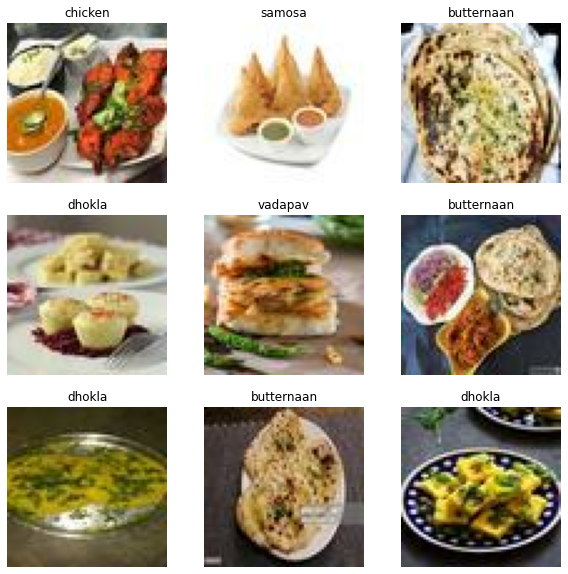

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 64, 64, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [13]:
num_classes = 6

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
142/142 [==============================] - 3s 20ms/step - loss: 1.3746 - accuracy: 0.4466 - val_loss: 1.0470 - val_accuracy: 0.6053
Epoch 2/15
142/142 [==============================] - 1s 7ms/step - loss: 0.9217 - accuracy: 0.6637 - val_loss: 0.9461 - val_accuracy: 0.6540
Epoch 3/15
142/142 [==============================] - 1s 5ms/step - loss: 0.7518 - accuracy: 0.7292 - val_loss: 0.8215 - val_accuracy: 0.7009
Epoch 4/15
142/142 [==============================] - 1s 4ms/step - loss: 0.6416 - accuracy: 0.7756 - val_loss: 0.8167 - val_accuracy: 0.7168
Epoch 5/15
142/142 [==============================] - 1s 4ms/step - loss: 0.5475 - accuracy: 0.8114 - val_loss: 0.6892 - val_accuracy: 0.7637
Epoch 6/15
142/142 [==============================] - 1s 4ms/step - loss: 0.4595 - accuracy: 0.8437 - val_loss: 0.6830 - val_accuracy: 0.7549
Epoch 7/15
142/142 [==============================] - 1s 4ms/step - loss: 0.3881 - accuracy: 0.8689 - val_loss: 0.6495 - val_accuracy: 0.7690
Epoch

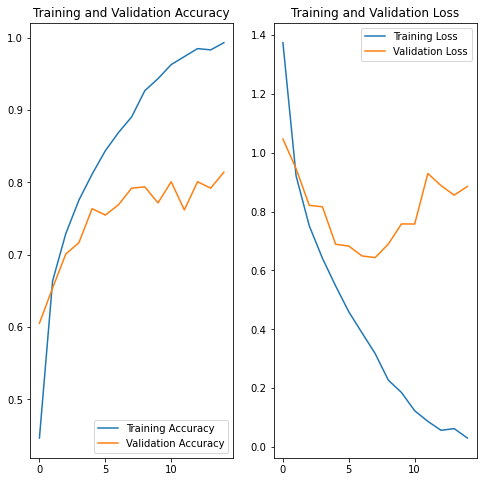

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [124]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [125]:
model.compile( optimizer=keras.optimizers.Adam(learning_rate=0.0008),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [126]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
142/142 [==============================] - 1s 7ms/step - loss: 1.3740 - accuracy: 0.4548 - val_loss: 1.2096 - val_accuracy: 0.5283
Epoch 2/25
142/142 [==============================] - 1s 6ms/step - loss: 1.0716 - accuracy: 0.5958 - val_loss: 1.0118 - val_accuracy: 0.6230
Epoch 3/25
142/142 [==============================] - 1s 6ms/step - loss: 0.9838 - accuracy: 0.6370 - val_loss: 1.0874 - val_accuracy: 0.6044
Epoch 4/25
142/142 [==============================] - 1s 6ms/step - loss: 0.8769 - accuracy: 0.6757 - val_loss: 0.9516 - val_accuracy: 0.6619
Epoch 5/25
142/142 [==============================] - 1s 6ms/step - loss: 0.8355 - accuracy: 0.6925 - val_loss: 0.8276 - val_accuracy: 0.6982
Epoch 6/25
142/142 [==============================] - 1s 6ms/step - loss: 0.7641 - accuracy: 0.7285 - val_loss: 0.7792 - val_accuracy: 0.7212
Epoch 7/25
142/142 [==============================] - 1s 6ms/step - loss: 0.7170 - accuracy: 0.7451 - val_loss: 0.8078 - val_accuracy: 0.7221
Epoch 

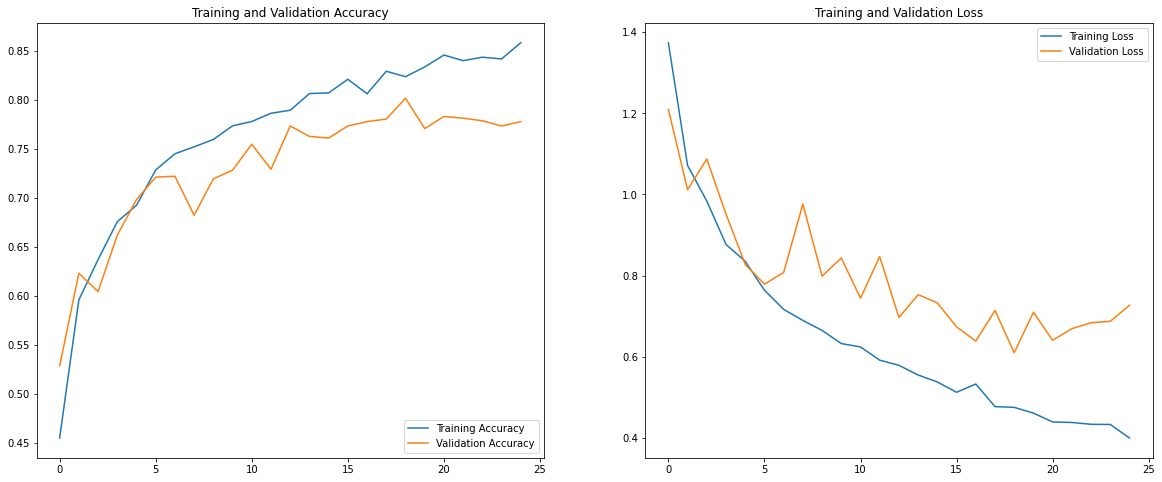

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [135]:
img = keras.preprocessing.image.load_img(
    '../input/testdata/testdata/6.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to vadapav with a 99.95 percent confidence.
